In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as scsp
import scipy.integrate as scint
import sys
sys.path.insert(0, '/users/milan/nudetect')
import nudetect

In [2]:
CIT2921 = nudetect.Source("Am241", 2921)

In [3]:
h119_Am241 = nudetect.GammaFlood("floodAm241_5C_-500V_20190815_small_region.fits",
                                 detector="H119",
                                 source = CIT2921,
                                 voltage = 500,
                                 temp=5,
                                 data_dir='data',
                                 plot_dir='plots'
                                )

In [4]:
h119_Am241.load_raw_data()

In [5]:
h119_Am241.gen_count_map()

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0,
  dtype=uint32)

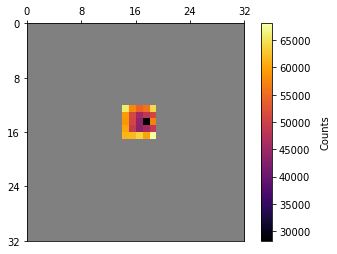

In [7]:
h119_Am241.plot_pixel_map('Count')
#h119_Am241.plot_pixel_hist('Count')

In [95]:
other_data, _ = nudetect.fits_to_df("floodAm241_5C_-500V_20190815_small_region.fits",
                                   ["GRADE"],
                                   pos=0)
tp_mask = (h119_Am241.raw_data_1d['STIM'] == 1)
grade_mask = (other_data['GRADE'] == 0)
bad_pix_mask = (h119_Am241.raw_data_1d['RAWX'] == 17) & (h119_Am241.raw_data_1d['RAWY'] == 14)

In [96]:
%%time
h119_Am241.gen_quick_gain(plot_subdir='gamma_pix', misc_mask=~(tp_mask | bad_pix_mask) & grade_mask)

/users/milan/nudetect/nudetect.py:4009: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()
/users/milan/nudetect/nudetect.py:4009: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()
/users/milan/nudetect/nudetect.py:4009: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()
/users/milan/nudetect/nudetect.py:4009: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()
/users/milan/nudetect/nudetect.py:4009: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()
/users/milan/nudetect/nudetect.py:4

CPU times: user 1min 29s, sys: 4.16 s, total: 1min 33s
Wall time: 1min 36s


masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0.0)

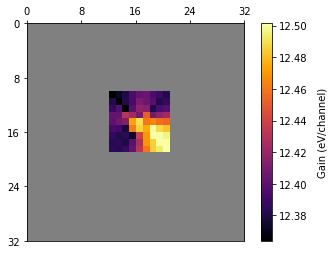

In [97]:
h119_Am241.plot_pixel_map('Gain')

In [98]:
%%time
h119_Am241.gen_spectrum(misc_mask=~(tp_mask | bad_pix_mask) & grade_mask)

CPU times: user 1min 54s, sys: 5.4 s, total: 1min 59s
Wall time: 2min 3s


array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 2.00000000e+00],
       [1.59995000e-02, 2.79985000e-02, 3.99975000e-02, ...,
        1.19970002e+02, 1.19982001e+02, 1.19994000e+02]])

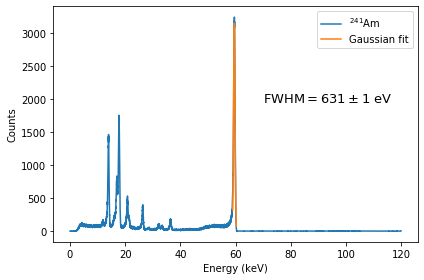

In [99]:
h119_Am241.plot_spectrum(fit_below=50, fit_above=60)

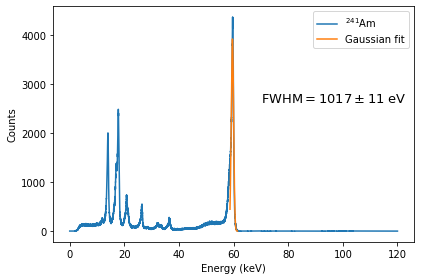

In [16]:
# no mask
h119_Am241.gen_quick_gain(save_plot=False, save_data=False)
h119_Am241.gen_spectrum(save_data=False)
h119_Am241.plot_spectrum(save_plot=False)

In [24]:
from matplotlib.colors import LogNorm

In [100]:
clean_grade0_spectrum = h119_Am241.spectrum

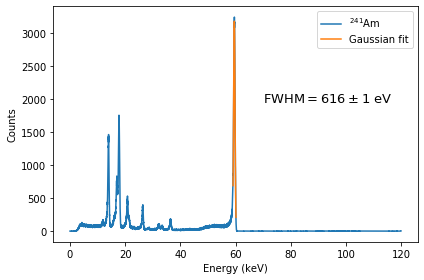

In [102]:
h119_Am241.plot_spectrum(spectrum=clean_grade0_spectrum, fit_below=40, fit_above=50)

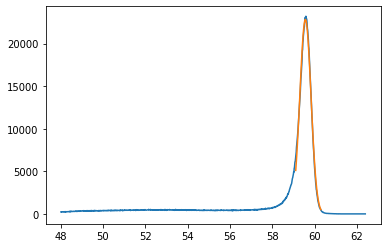

In [264]:
plt.plot(clean_grade0_spectrum[1][4000:5200], clean_grade0_spectrum[0][4000:5200])
plt.plot(clean_grade0_spectrum[1][4925:5025], line(clean_grade0_spectrum[1][4925:5025]))

In [21]:
clean_grade0_spectrum[0].argmax()

4974

In [20]:
from astropy.modeling import models, fitting

In [254]:
line_init = models.Gaussian1D(amplitude=22000, mean=59.7, stddev=0.8)
fit_line = fitting.LevMarLSQFitter()
line = fit_line(line_init, clean_grade0_spectrum[1][4925:5025], clean_grade0_spectrum[0][4925:5025])

In [255]:
line.stddev * 2.355

0.6229666673634122

In [28]:
from scipy.interpolate import UnivariateSpline

In [103]:
spline = UnivariateSpline(clean_grade0_spectrum[1][4930:5000],
                          clean_grade0_spectrum[0][4930:5000] - clean_grade0_spectrum[0][4930:5000].max()/2, s=0.001)
roots = spline.roots() # find the roots

In [104]:
roots[1] - roots[0]

0.6080545679462901

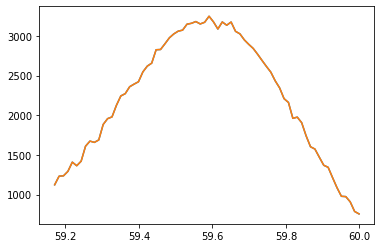

In [105]:
plt.plot(clean_grade0_spectrum[1][4930:5000], clean_grade0_spectrum[0][4930:5000])
plt.plot(clean_grade0_spectrum[1][4930:5000], spline(clean_grade0_spectrum[1][4930:5000]) + clean_grade0_spectrum[0].max()/2)

In [201]:
spline.roots()

array([59.25736209, 59.87291564, 59.99129095, 59.99687482])

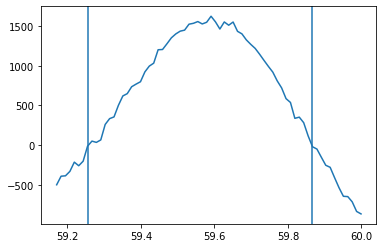

In [106]:
plt.plot(clean_grade0_spectrum[1][4930:5000], spline(clean_grade0_spectrum[1][4930:5000]))
for r in spline.roots():
    plt.axvline(r)

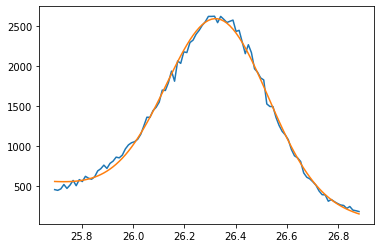

0.4677711677789126
2140


In [365]:
upper=2240
lower=2140

line_init = models.Gaussian1D(amplitude=3000, mean=26, stddev=0.8) + models.Linear1D(slope=-0.001, intercept=100)
fit_line = fitting.LevMarLSQFitter()
line = fit_line(line_init, clean_grade0_spectrum[1][lower:upper], clean_grade0_spectrum[0][lower:upper])
plt.plot(clean_grade0_spectrum[1][lower:upper], clean_grade0_spectrum[0][lower:upper])
plt.plot(clean_grade0_spectrum[1][lower:upper], line(clean_grade0_spectrum[1][lower:upper]))
plt.show()
print(line.stddev_0*2.355)

0.5157764570921799


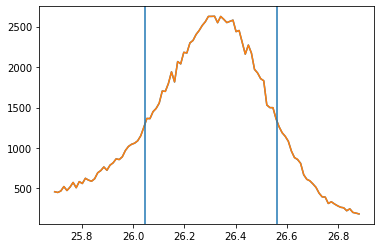

In [370]:
spline = UnivariateSpline(clean_grade0_spectrum[1][lower:upper],
                          clean_grade0_spectrum[0][lower:upper] - clean_grade0_spectrum[0][lower:upper].max()/2)
roots = spline.roots() # find the roots
print(roots[1] - roots[0])
plt.plot(clean_grade0_spectrum[1][lower:upper], clean_grade0_spectrum[0][lower:upper])
plt.plot(clean_grade0_spectrum[1][lower:upper], spline(clean_grade0_spectrum[1][lower:upper]) + clean_grade0_spectrum[0][lower:upper].max()/2)
plt.axvline(roots[0])
plt.axvline(roots[1])

0.614695731970162


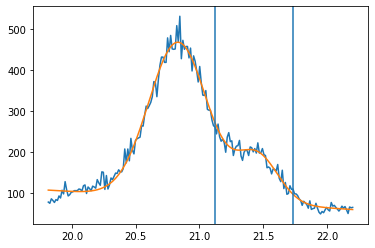

In [357]:
upper=1850
lower=1650

line_init = models.Gaussian1D(amplitude=500, mean=20.7, stddev=0.4) + models.Linear1D(slope=-1, intercept=100) + \
    models.Gaussian1D(amplitude=200, mean=21.5, stddev=0.4)
fit_line = fitting.LevMarLSQFitter()
line = fit_line(line_init, clean_grade0_spectrum[1][lower:upper], clean_grade0_spectrum[0][lower:upper])
plt.plot(clean_grade0_spectrum[1][lower:upper], clean_grade0_spectrum[0][lower:upper])
plt.plot(clean_grade0_spectrum[1][lower:upper], line(clean_grade0_spectrum[1][lower:upper]))

lower=1750
spline = UnivariateSpline(clean_grade0_spectrum[1][lower:upper],
                          line[1:](clean_grade0_spectrum[1][lower:upper]) - line[1:](clean_grade0_spectrum[1][lower:upper]).max()/2)
roots = spline.roots() # find the roots
print(roots[1] - roots[0])
plt.axvline(roots[0])
plt.axvline(roots[1])

In [132]:
clean_grade0_spectrum[1][5000]

60.0109995

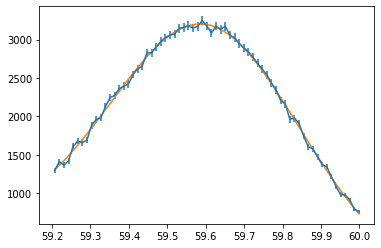

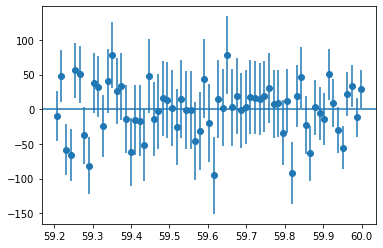

0.7678218175274625
0.6117582082842645
Model: CompoundModel41
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Gaussian1D(amplitude=3000., mean=59.6, stddev=0.3)>

    [1]: <Linear1D(slope=-1., intercept=10.)>
Parameters:
       amplitude_0           mean_0      ...      slope_1          intercept_1   
    ------------------ ----------------- ... ------------------ -----------------
    2975.1035990868104 59.59866183709552 ... -667.7715603865305 40022.22332311859


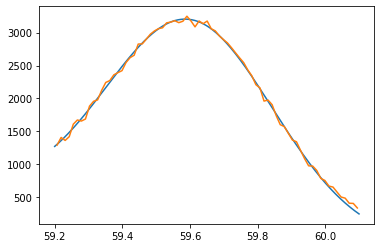

In [133]:
upper=4995
lower=4930
lower=4933
upper=5000

line_init = models.Gaussian1D(amplitude=3000, mean=59.6, stddev=0.3) + models.Linear1D(slope=-1, intercept=10-0)
fit_line = fitting.LevMarLSQFitter()
line = fit_line(line_init, clean_grade0_spectrum[1][lower:upper], clean_grade0_spectrum[0][lower:upper])
plt.errorbar(clean_grade0_spectrum[1][lower:upper], clean_grade0_spectrum[0][lower:upper],
             yerr=np.sqrt(clean_grade0_spectrum[0][lower:upper]))
plt.plot(clean_grade0_spectrum[1][lower:upper], line(clean_grade0_spectrum[1][lower:upper]))
plt.show()

plt.errorbar(clean_grade0_spectrum[1][lower:upper],
             clean_grade0_spectrum[0][lower:upper] - line(clean_grade0_spectrum[1][lower:upper]),
             yerr=np.sqrt(clean_grade0_spectrum[0][lower:upper]),
             fmt='o'
            )
plt.axhline(0)
plt.show()

chisq_red = np.sum(((clean_grade0_spectrum[0][lower:upper] - line(clean_grade0_spectrum[1][lower:upper])) ** 2)/\
                   clean_grade0_spectrum[0][lower:upper])/len(clean_grade0_spectrum[0][lower:upper] - 5)

print(chisq_red)
xs = np.linspace(59.2, 60.1, int(1e6))
spline = UnivariateSpline(xs,
                          line(xs) - line(xs).max()/2)
roots = spline.roots() # find the roots
plt.plot(xs, spline(xs)+line(xs).max()/2)
plt.plot(clean_grade0_spectrum[1][np.abs(clean_grade0_spectrum[1] - 59.65) < 0.45],
         clean_grade0_spectrum[0][np.abs(clean_grade0_spectrum[1] - 59.65) < 0.45])
del xs, spline
print(roots[1] - roots[0])
print(line)

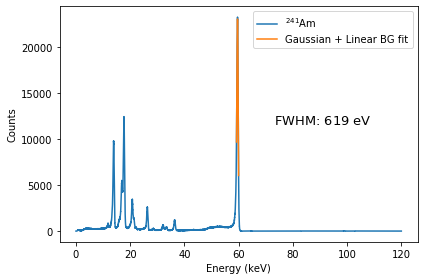

In [565]:
plt.plot(clean_grade0_spectrum[1], clean_grade0_spectrum[0], label='${}^{241}$Am')
plt.plot(clean_grade0_spectrum[1][lower:upper], line(clean_grade0_spectrum[1][lower:upper]), label='Gaussian + Linear BG fit')
plt.text(0.6, 0.5, f'FWHM: ${619:.0f}$ eV', transform=plt.gca().transAxes, fontsize=13)
plt.legend()
#plt.title('Full Frame Spectrum, Single Pixel Events Only')
plt.ylabel('Counts')
plt.xlabel('Energy (keV)')
plt.tight_layout()
plt.savefig('energy_spectrum_floodAm241_5C_-500V_20190725_gain_grade0_GaussLinBG.pdf')

In [487]:
line

<CompoundModel115(amplitude_0=21115.3998748, mean_0=59.60044444, stddev_0=0.24368647, slope_1=-5104.3561973, intercept_1=306063.72795554)>

In [447]:
np.sqrt(fit_line.fit_info['cov_x'][2,2])*2.355*1000

0.05092735941567342

In [457]:
2.355*1000*np.sqrt(fit_line.fit_info['cov_x'][2,2]*((clean_grade0_spectrum[0][lower:upper] - line(clean_grade0_spectrum[1][lower:upper])) ** 2).sum()/(len(line(clean_grade0_spectrum[1][lower:upper])) - 5))

6.64907217768257

In [469]:
np.sqrt(fit_line.fit_info['param_cov'][2,2])*2.355*1000

6.64907217768257

In [483]:
def pixel_mask(x, y):
    return (h119_Am241.raw_data_1d['RAWX'] == x) & (h119_Am241.raw_data_1d['RAWY'] == y)

0.6101102477852365


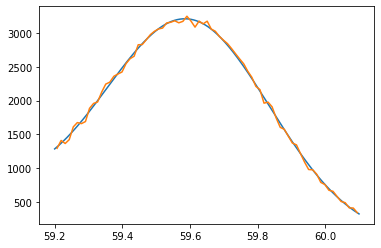

In [108]:
xs = np.linspace(59.2, 60.1, int(1e6))
spline = UnivariateSpline(xs,
                          line(xs) - line(xs).max()/2)
roots = spline.roots() # find the roots
plt.plot(xs, spline(xs)+line(xs).max()/2)
plt.plot(clean_grade0_spectrum[1][np.abs(clean_grade0_spectrum[1] - 59.65) < 0.45],
         clean_grade0_spectrum[0][np.abs(clean_grade0_spectrum[1] - 59.65) < 0.45])
del xs, spline
print(roots[1] - roots[0])

In [541]:
clean_grade0_spectrum[1][4999]

59.999000499999994

In [532]:
line

<CompoundModel125(amplitude_0=22534.64651141, mean_0=59.60100535, stddev_0=0.25769821, slope_1=-5350.04403953, intercept_1=319200.21696186)>

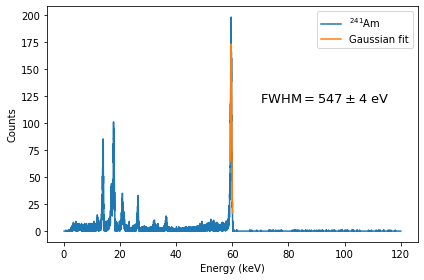

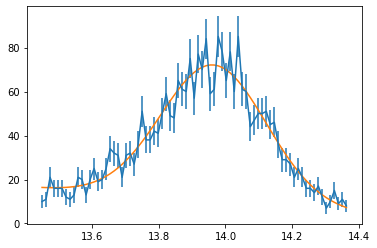

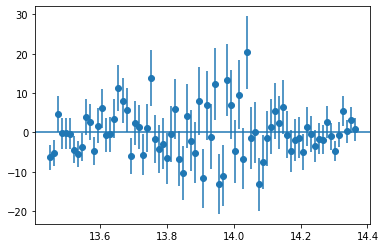

0.9840856310741046


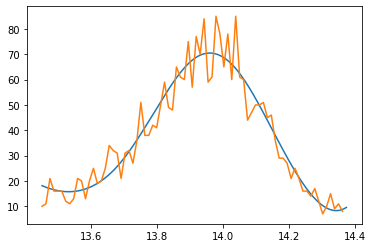

0.42812765201994907


In [321]:
i, j = 17, 12
cts, edges = np.histogram(h119_Am241._energy_map[j][i], bins=10000, range=(0.1, 120))
h119_Am241.plot_spectrum(spectrum=np.array([cts, edges[:-1]*0.5 + edges[1:]*0.5]), save_plot=False,
                         fit_below=30, fit_above=40)
plt.show()
#print(i,j)
fwhm, line = fit_line(np.array([cts, edges[:-1]*0.5 + edges[1:]*0.5]), lower=1113, upper=1190, energy=13.95,
                                  plot=True)
            #fwhm, line = fit_line(np.array([cts, edges[:-1]*0.5 + edges[1:]*0.5]), lower=4930, upper=5000, plot=False)
            #fwhm_map[i][j] = fwhm*1000
#            fwhm_map_low[i][j] = fwhm*1000
        
#fwhm_map = np.ma.masked_equal(fwhm_map, 1)
#fwhm_map_low = np.ma.masked_equal(fwhm_map_low, 1)

In [322]:
i, j = 17, 12
#fwhm_map = np.ones((32,32))
fwhm_map_low = np.ones((32,32))
for i in range(14,19):
    for j in range(12,17):
        if len(h119_Am241._energy_map[j][i]):
            cts, edges = np.histogram(h119_Am241._energy_map[j][i], bins=10000, range=(0.1, 120))
#h119_Am241.plot_spectrum(spectrum=np.array([cts, edges[:-1]*0.5 + edges[1:]*0.5]), save_plot=False,
#                         fit_below=30, fit_above=40)
#plt.show()
            print(i,j)
            fwhm, line = fit_line(np.array([cts, edges[:-1]*0.5 + edges[1:]*0.5]), lower=1113, upper=1190, energy=13.95,
                                  plot=False)
            #fwhm, line = fit_line(np.array([cts, edges[:-1]*0.5 + edges[1:]*0.5]), lower=4930, upper=5000, plot=False)
            #fwhm_map[i][j] = fwhm*1000
            fwhm_map_low[i][j] = fwhm*1000
        
#fwhm_map = np.ma.masked_equal(fwhm_map, 1)
fwhm_map_low = np.ma.masked_equal(fwhm_map_low, 1)

14 12
1.2958669676049568
0.5334645596081877
14 13
0.9874427297675661
0.4826155281495712
14 14
1.6760236873371288
0.4911485589233262
14 15
1.1501867832676507
0.49667901242838575
14 16
1.119209735487146
0.5593182483051091
15 12
1.0671950688890603
0.4571103503160323
15 13
1.065217490091168
0.4687671405295042
15 14
0.7648699819433004
0.46007895432395607
15 15
1.0126528196226285
0.4555916023785169
15 16
0.9465983363851077
0.4655284518402265
16 12
0.838830112669692
0.475468583515152
16 13
1.6785427178827255
0.4180629922532759
16 14
1.4897006569456335
0.652951616229009
16 15
0.9764079585521058
0.4629190268970653
16 16
1.0416093884161974
0.5272221445427991
17 12
0.9840856310741046
0.42812765201994907
17 13
0.9987907787101277
0.6442883490669047
17 15
1.5555922132634663
0.41202732287911026
17 16
0.8308818565761849
0.4746545633316419
18 12
1.1902960508204368
0.46662428912357967
18 13
1.024116277251368
0.6098507860108722
18 14
1.5434464751878292
0.6070962071625416
18 15
0.9186847375994472
0.516022

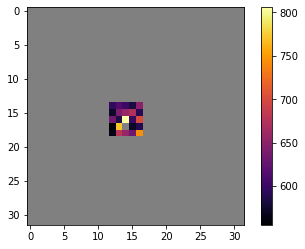

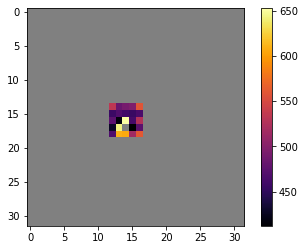

In [323]:
cmap = matplotlib.cm.get_cmap('inferno')
cmap.set_bad(color='gray')
plt.imshow(fwhm_map, cmap = cmap)
plt.colorbar()
plt.show()

cmap = matplotlib.cm.get_cmap('inferno')
cmap.set_bad(color='gray')
plt.imshow(fwhm_map_low, cmap = cmap)
plt.colorbar()
plt.show()

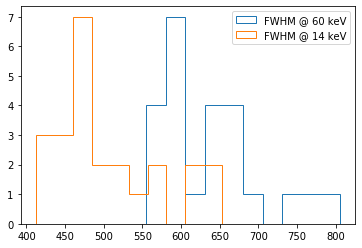

In [328]:
plt.hist(fwhm_map.data.flatten()[fwhm_map.data.flatten() > 1], histtype='step', label='FWHM @ 60 keV')
plt.hist(fwhm_map_low.data.flatten()[fwhm_map_low.data.flatten() > 1], histtype='step', label='FWHM @ 14 keV')
plt.legend()
plt.show()

In [276]:
import matplotlib

In [299]:
def fit_line(spec, lower=4920, upper=5010, energy=59.6, plot=True):
    #upper=4995
    #lower=4930
    #lower=4920
    #upper=5010

    line_init = models.Gaussian1D(amplitude=np.max(spec[0]), mean=energy, stddev=0.3) + models.Linear1D(slope=-20, intercept=1000)
    fit_l = fitting.LevMarLSQFitter()
    line = fit_l(line_init, spec[1][lower:upper], spec[0][lower:upper])
    if plot:
        plt.errorbar(spec[1][lower:upper], spec[0][lower:upper],
             yerr=np.sqrt(spec[0][lower:upper]))
        plt.plot(spec[1][lower:upper], line(spec[1][lower:upper]))
        plt.show()

        plt.errorbar(spec[1][lower:upper],
             spec[0][lower:upper] - line(spec[1][lower:upper]),
             yerr=np.sqrt(spec[0][lower:upper]),
             fmt='o'
            )
        plt.axhline(0)
        plt.show()
    
    screened_cts = np.maximum(spec[0][lower:upper], 1)

    chisq_red = np.sum(((spec[0][lower:upper] - line(spec[1][lower:upper])) ** 2)/
                   screened_cts)/len(spec[0][lower:upper] - 5)

    print(chisq_red)
    xs = np.linspace(spec[1][lower], spec[1][upper], int(1e6))
    spline = UnivariateSpline(xs,
                          line(xs) - line(xs).max()/2)
    roots = spline.roots() # find the roots
    if plot:
        plt.plot(xs, spline(xs)+line(xs).max()/2)
        plt.plot(spec[1][lower:upper],
         spec[0][lower:upper])
        plt.show()
    del xs, spline
    print(roots[1] - roots[0])
    return roots[1] - roots[0], line
    #print(line)

0.757551542403575
0.6152702123126375
0.9913506725486694
0.5053145376024482


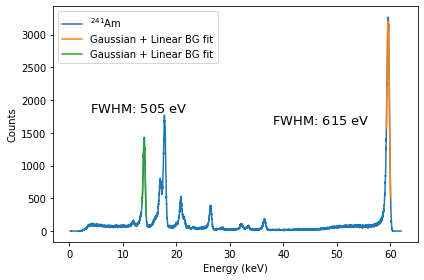

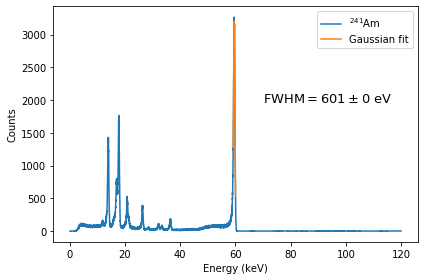

In [265]:
best_pixels = [(14, 12), (14, 14), (14, 15),
              (15, 16),
              (16, 13), (16, 15),
              (17, 12), (17, 15), (17, 16),
              (18, 12)]
#best_pixels = [(17, 12), (18, 12), (17, 15)]
best_energy_map = []
#for i, j in best_pixels:
for i in range(14,19):
    for j in range(12,17):
        best_energy_map += h119_Am241._energy_map[j][i]

cts, edges = np.histogram(best_energy_map, bins=10000, range=(0.1, 120))
spec = np.array([cts, edges[:-1]*0.5 + edges[1:]*0.5])


lower=4933
upper=5000
fwhm, line = fit_line(spec, lower=lower, upper=upper, plot=False)

plt.plot(spec[1][(spec[1] < 62) & (spec[1] > 0)], spec[0][(spec[1] < 62) & (spec[1] > 0)], label='${}^{241}$Am')
plt.plot(spec[1][lower:upper], line(spec[1][lower:upper]), label='Gaussian + Linear BG fit')
plt.text(0.6, 0.5, f'FWHM: ${fwhm*1000:.0f}$ eV', transform=plt.gca().transAxes, fontsize=13)

lower=1120
upper=1190
fwhm, line = fit_line(spec, lower=lower, upper=upper, energy=14, plot=False)
plt.plot(spec[1][lower:upper],
         line(spec[1][lower:upper]),
         label='Gaussian + Linear BG fit')
plt.text(0.1, 0.55, f'FWHM: ${fwhm*1000:.0f}$ eV', transform=plt.gca().transAxes, fontsize=13)


plt.legend()
#plt.title('10 Best Pixels Between (14, 12) and (18, 16), Single Pixel Events Only')
plt.ylabel('Counts')
plt.xlabel('Energy (keV)')
plt.tight_layout()
plt.show()
h119_Am241.plot_spectrum(spectrum=np.array([cts, edges[:-1]*0.5 + edges[1:]*0.5]), save_plot=False,
                         fit_below=30, fit_above=40)
plt.show()


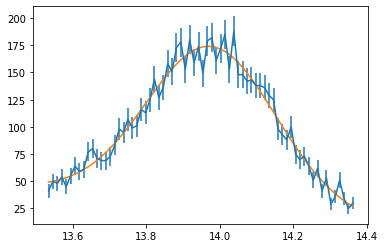

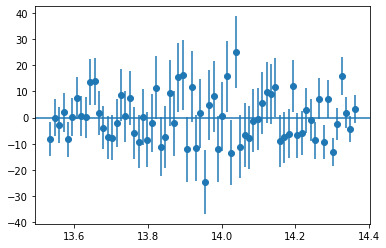

0.8574638100076426


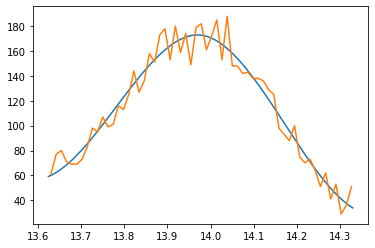

0.47988043276486536


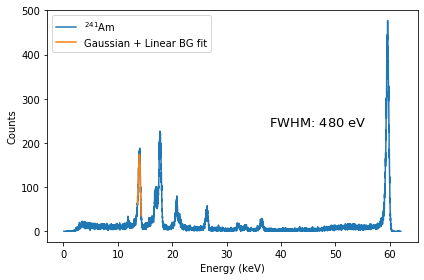

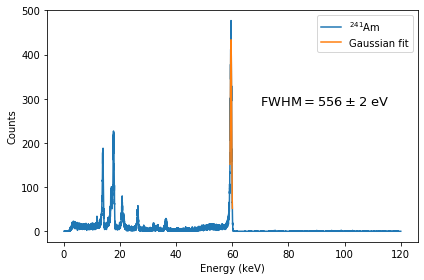

In [263]:
best_pixels = [(14, 12), (14, 14), (14, 15),
              (15, 16),
              (16, 13), (16, 15),
              (17, 12), (17, 15), (17, 16),
              (18, 12)]
best_pixels = [(17, 12), (18, 12), (17, 15)]
best_energy_map = []
for i, j in best_pixels:
    best_energy_map += h119_Am241._energy_map[j][i]

cts, edges = np.histogram(best_energy_map, bins=10000, range=(0.1, 120))
spec = np.array([cts, edges[:-1]*0.5 + edges[1:]*0.5])

fwhm, line = fit_line(spec, lower=1120, upper=1190, energy=14)


plt.plot(spec[1][(spec[1] < 62) & (spec[1] > 0)], spec[0][(spec[1] < 62) & (spec[1] > 0)], label='${}^{241}$Am')
plt.plot(spec[1][(spec[1] < line.mean_0+line.stddev_0*2) & (spec[1] > line.mean_0-line.stddev_0*2)],
         line(spec[1][(spec[1] < line.mean_0+line.stddev_0*2) & (spec[1] > line.mean_0-line.stddev_0*2)]),
         label='Gaussian + Linear BG fit')
plt.text(0.6, 0.5, f'FWHM: ${fwhm*1000:.0f}$ eV', transform=plt.gca().transAxes, fontsize=13)
plt.legend()
#plt.title('10 Best Pixels Between (14, 12) and (18, 16), Single Pixel Events Only')
plt.ylabel('Counts')
plt.xlabel('Energy (keV)')
plt.tight_layout()
plt.show()
h119_Am241.plot_spectrum(spectrum=np.array([cts, edges[:-1]*0.5 + edges[1:]*0.5]), save_plot=False,
                         fit_below=30, fit_above=40)
plt.show()


In [ ]:
plt.hist([h119_Am241.raw_data_1d.loc[pixel_mask(17, 14) & (other_data['GRADE'] == 0)]['PH'],
          h119_Am241.raw_data_1d.loc[pixel_mask(17, 14) & (other_data['GRADE'] == 1)]['PH'],
          h119_Am241.raw_data_1d.loc[pixel_mask(17, 14) & (other_data['GRADE'] == 2)]['PH'],
          h119_Am241.raw_data_1d.loc[pixel_mask(17, 14) & (other_data['GRADE'] == 3)]['PH'],
          h119_Am241.raw_data_1d.loc[pixel_mask(17, 14) & (other_data['GRADE'] == 4)]['PH'],
          h119_Am241.raw_data_1d.loc[pixel_mask(17, 14) & (other_data['GRADE'] == 4)]['PH'],
          h119_Am241.raw_data_1d.loc[pixel_mask(17, 14) & (other_data['GRADE'] == 4)]['PH']],
         np.arange(1, 6000), histtype='barstacked')
plt.savefig('energy_spectrum_Am241_17_14_by_grade.pdf')
plt.show()

plt.hist(other_data[pixel_mask(17, 14)]['GRADE'], bins=np.arange(14))
plt.show()

In [329]:
def pixel_mask(x, y):
    return (h119_Am241.raw_data_1d['RAWX'] == x) & (h119_Am241.raw_data_1d['RAWY'] == y)

(array([273194., 688292., 123790., 126533., 126325., 119965.,  21889.,
         16393.,  16344.,  19321.,  35172.,  18332.,  43519.]),
 array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,
        12.]),
 <a list of 13 Patch objects>)

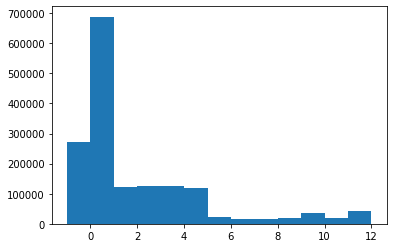

In [344]:
plt.hist(other_data['GRADE'], bins=13)